In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import foldnorm

from emely import GaussianMLE, FoldedGaussianMLE

In [2]:
# define plot style
violet = "#785ef0"
blue = "#648fff"
yellow = "#ffb000"
orange = "#fe6100"
red = "#dc267f"
black = "000000"
gray = "cccccc"
white = "ffffff"

plt.style.use("seaborn-v0_8")
plt.rcParams["figure.dpi"] = 300


### Overview

This notebook compares the deviance of different estimators when fitting a Lorentzian model with **folded Gaussian noise** _without providing initial parameters or sigma_y_.

### Model and noise

We estimate the parameters $\theta = (a, \omega_0, \gamma)$ of a Lorentzian curve:

$
f(\omega, \theta) = \frac{a}{\sqrt{(\omega^2 - \omega_0^2)^2 + \gamma^2 \omega^2}}
$,

from noisy measurements

$
y(\omega) = f(\omega, \theta) + \varepsilon
$,

where the noise term $ \varepsilon $ follows **folded Gaussian statistics**. 

We fit the same data with the GaussianMLE and FoldedGaussianMLE estimators and compare their deviances. The estimator that assumes the correct noise distribution should have the lowest deviance.

### Physical Context

In this physical setting, the function $f(\omega, \theta)$ represents the oscillation amplitude $y(\omega)$ of a driven, damped harmonic oscillator. The parameter $a$ corresponds to the ratio of the driving force to the mass,

$
a = \frac{F_0}{m},
$

so the Lorentzian model directly describes the absolute deflection amplitude as a function of frequency.


In [3]:
# define the model to fit
def lorentzian(omega, a, omega_0, gamma):
    return a / np.sqrt((omega**2 - omega_0**2) ** 2 + gamma**2 * omega**2)


In [4]:
# define model parameters
domega = 0.2  # (rad)
omega_0 = 10  # (rad)
gamma = 2  # (rad)
a = 10  # (m/s^2)
p = (a, omega_0, gamma)

# define model variables
omega_rng = (omega_0 - 3 * gamma, omega_0 + 3 * gamma)
n_omega = round((omega_rng[1] - omega_rng[0]) / domega) + 1
omega = omega_rng[0] + domega * np.arange(n_omega)

# set the random seed
np.random.seed(0)


In [5]:
# create the measurement
sigma_noise = 0.1  # (m)
f_omega = lorentzian(omega, *p)
y_omega = foldnorm.rvs(c=f_omega / sigma_noise, scale=sigma_noise, loc=0)

# define initial guesses and bounds
params_init = None
param_bounds = (
    [0, 0, 0],
    [100, 100, 10],
)


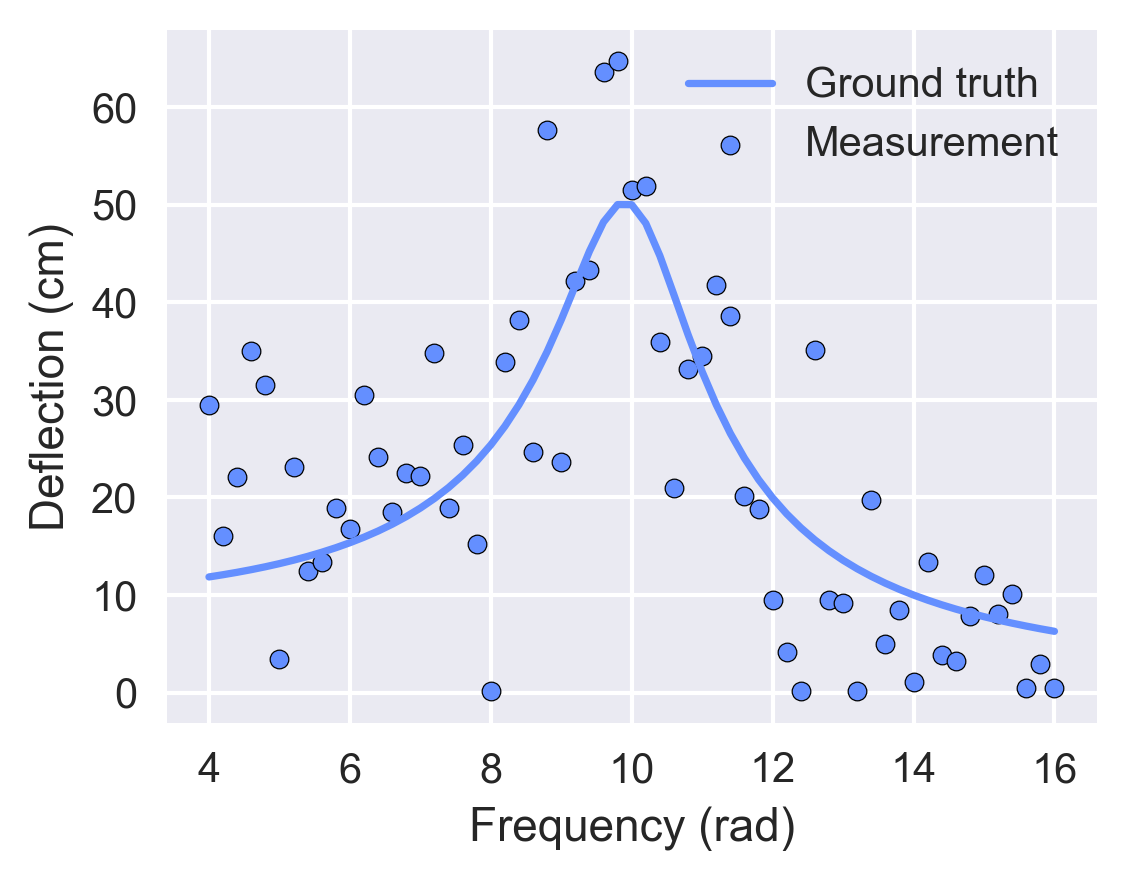

In [6]:
# show the measurement and the fit
fig, ax = plt.subplots(figsize=(4, 3))

ax.plot(omega, 1e2 * f_omega, label="Ground truth", color=blue, zorder=10)
ax.scatter(
    omega,
    1e2 * y_omega,
    label="Measurement",
    s=20,
    facecolor=blue,
    edgecolor=black,
    zorder=5,
)

ax.set_xlabel("Frequency (rad)")
ax.set_ylabel("Deflection (cm)")
ax.legend()

In [7]:
# fit with all estimators and compare deviances
estimators = {
    "GaussianMLE": GaussianMLE(lorentzian, verbose=False),
    "FoldedGaussianMLE": FoldedGaussianMLE(lorentzian, verbose=False),
}

deviances = {}
for name, estimator in estimators.items():
    estimator.fit(
        omega,
        y_omega,
        params_init=params_init,
        param_bounds=param_bounds,
    )
    deviances[name] = estimator.deviance
    print(f"{name}: {deviances[name]:.2f}")

print("\nLowest deviance (best fit):", min(deviances, key=deviances.get))


GaussianMLE: -106.83
FoldedGaussianMLE: -122.98

Lowest deviance (best fit): FoldedGaussianMLE
